Pre-processing
* Visualization
1. Unix time
2. Encoding of categorical features
3. Temporal ordering
4. Aditional features:
- Previous event
- Next event
- Day of the week
- Time of day
- Event duration
5. Separate 80-20 
- Visualization
6. Get rid of overlap

In [129]:
import os
import psutil
import numpy as np  # import auxiliary library, typical idiom
import pandas as pd  # import the Pandas library, typical idiom
from pandas import read_csv
import statsmodels.api as sm
import time 
import pm4py
from datetime import datetime
from datetime import date
from datetime import datetime
from datetime import timedelta

from numba import jit

from sklearn.linear_model import LinearRegression  # for linear regression
from sklearn import linear_model
from sklearn.cluster import KMeans  # for clustering
from sklearn.tree import DecisionTreeClassifier  # for decision tree mining
from sklearn.metrics import mean_absolute_error, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from matplotlib import pyplot
from sklearn.preprocessing import OrdinalEncoder

In [112]:
file_export = 'export2012.csv'
data = pd.read_csv(file_export)

In [ ]:
#visualization (no need to include in main code, but might be useful)
log = pm4py.read_xes('BPI_Challenge_2012.xes')

process_tree = pm4py.discover_tree_inductive(log)
pm4py.view_process_tree(process_tree)


In [114]:
#unix time
pd.set_option('display.float_format', lambda x: '%.3f' % x)

data['startTime'] = pd.to_datetime(data['startTime'], dayfirst=True)
unixTransform = lambda x: time.mktime(x.timetuple())
data["UNIX_starttime"] = data["startTime"].apply(unixTransform).astype(int)

data['completeTime'] = pd.to_datetime(data['completeTime'], dayfirst=True)
unixTransform = lambda x: time.mktime(x.timetuple())
data["UNIX_completeTime"] = data["completeTime"].apply(unixTransform).astype(int)

data['REG_DATE'] = pd.to_datetime(data['REG_DATE'], dayfirst=True)
unixTransform = lambda x: time.mktime(x.timetuple())
data["UNIX_REG_DATE"] = data["REG_DATE"].apply(unixTransform).astype(int)

#print(data)

In [115]:
#encoding of categorical data
ordinal_encoder = OrdinalEncoder()
data['enc_event'] = ordinal_encoder.fit_transform(data[['event']]).astype(int)

In [116]:
#sorting on time
data.sort_values(by = "UNIX_starttime", ignore_index=True)

,case,event,startTime,completeTime,AMOUNT_REQ,REG_DATE,org:resource,UNIX_starttime,UNIX_completeTime,UNIX_REG_DATE,enc_event
0,173688,A_SUBMITTED,2011-10-01 00:38:44.546,2011-10-01 00:38:44.546,20000,2011-10-01 00:38:44.546,112,1317429524,1317429524,1317429524,9
1,173688,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880,2011-10-01 00:38:44.880,20000,2011-10-01 00:38:44.546,112,1317429524,1317429524,1317429524,6
2,173688,A_PREACCEPTED,2011-10-01 00:39:37.906,2011-10-01 00:39:37.906,20000,2011-10-01 00:38:44.546,112,1317429577,1317429577,1317429524,7
3,173688,A_PREACCEPTED,2011-10-01 00:39:37.906,2011-10-01 00:39:37.906,20000,2011-10-01 00:38:44.546,112,1317429577,1317429577,1317429524,7
4,173691,A_SUBMITTED,2011-10-01 08:08:58.256,2011-10-01 08:08:58.256,5000,2011-10-01 08:08:58.256,112,1317456538,1317456538,1317456538,9
...,...,...,...,...,...,...,...,...,...,...,...
190822,212689,W_Nabellen incomplete dossiers,2012-03-14 15:56:14.517,2012-03-14 15:58:57.002,2000,2012-02-25 11:24:12.200,10863,1331740574,1331740737,1330169052,20
190823,212689,W_Nabellen incomplete dossiers,2012-03-14 15:56:14.517,2012-03-14 15:58:57.002,2000,2012-02-25 11:24:12.200,10863,1331740574,1331740737,1330169052,20
190824,213276,W_Nabellen incomplete dossiers,2012-03-14 15:59:28.309,2012-03-14 16:00:09.680,15000,2012-02-27 14:12:41.868,10863,1331740768,1331740809,1330351961,20
190825,209595,W_Nabellen offertes,2012-03-14 16:02:03.883,2012-03-14 16:02:03.883,13000,2012-02-15 10:10:36.503,11169,1331740923,1331740923,1329300636,21


In [117]:
#previous event
data['prev_event'] = data.groupby('case')['event'].shift(1)

#next event
data['next_event'] = data.groupby('case')['event'].shift(-1)

#duration

#day of the week

#time of day


In [156]:
#separation
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [157]:
#removing overlap - if case is in both datasets, remove

train_cases = train['case'].unique().tolist()
test_cases = test['case'].unique().tolist()

intersect_list = list(set(train_cases).intersection(test_cases))

In [161]:
#only removes first value in intersect list (needs modification for multiple overlaping values)

#train = train[train['case'] != intersect_list[0]]
#test = test[test['case'] != intersect_list[0]]

#works for more values

train = train[train['case'].isin(intersect_list) == False]
test = test[test['case'].isin(intersect_list) == False]

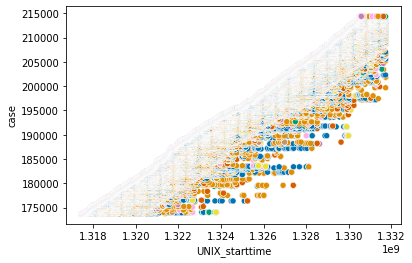

In [162]:
#separation visualisation

g = sns.scatterplot(x="UNIX_starttime", y="case", hue="enc_event", data=data, palette='colorblind', legend=False)

#add lines for separation - horizontal and vertical
